# Modeling memory accesses

## Access Relations
<!-- Each statement instance may access one or more variables, scalars or arrays. -->
每个statement instance可能会访问一个或多个的variables/ scalars/ arrays.
<!-- If the array subscripts are affine forms of loop iterators and structure parameters, -->
<!-- one can define a Presburger relation that associates statement instances to the array elements they access. -->
<!-- Scalars are usually considered as zero-dimensional arrays in the polyhedral model for the sake of consistency. -->
如果数组的下标索引是loop iterators 和 structure parameters的仿射形式,
那么可以定义Presburger relation来将statement instances和他们访问的数组元素关联起来.
为了简单起见,在polyhedral model中将scalar作为0维数组来表示.


<!-- Consider the polynomial multiplication kernel -->
考虑一个矩阵乘的算子:
```c
double X[100], Y[100], Z[200];
double zero = 0.;

for (int i = 0; i <= 200; ++i)
S:  Z[i] = zero;
for (int i = 0; i <= 100; ++i)
    for (int j = 0; j <= 100; ++j)
T:      Z[i + j] += A[i] * B[j];
```

<!-- Using only syntactic terms, we can say that statement `S` accesses array `Z`. -->
如果只使用句法术语, 可以称为statement `S` 访问 array `Z`.

<!-- However, each individual *instance* $( \mathtt{S}(i) )$ only accesses one array element, `Z[i]`. -->
但是,对于每一个独立的*instance*$( \mathtt{S}(i) )$ 只访问其中的一个元素`Z[i]`.
<!-- This can be encoded by a relation $( \{ \mathtt{S}(i) \\rightarrow \mathtt{Z}(a): a = i \} )$. -->
这可以被编码为 $( \{ \mathtt{S}(i) \rightarrow \mathtt{Z}(a): a = i \} )$.
<!-- Furthermore, we know the size of the array `Z` so we can define constraints on $(a)$ that avoid out-of-memory accesses, -->
进一步, 我们知道array `Z`的size,因此可以定义额外的约束来避免index out of range.
$( \{ \mathtt{Z}(a): 0 \leq a \leq 200 \} )$.
<!-- At the same time, the iteration domain of `S` is -->
同时`S`的iteration domain为:
$( \{ \mathtt{S}(i): 0 \leq i \leq 200 \} )$.
<!-- To plug these constraints into the access relation, we can intersect its *domain* with the iteration domain and its *range* with the array size constraint set. -->
在access relation中加入了以上约束后, 我们可以将上述set和statement domain进行intersect.

In [36]:
import islpy as isl
A_S_Z = isl.Map("{S[i] -> Z[a]: a = i}") # s访问数组z的映射
D_S = isl.Set("{S[i]: 0 <= i <= 200}") # S的迭代域
C_Z = isl.Set("{Z[a]: 0 <= a <= 200}") # 数组Z的domain
A_S_Z = A_S_Z.intersect_domain(D_S).intersect_range(C_Z) # 对schedule添加instance domain和数组的range.
print(A_S_Z)

{ S[i] -> Z[a = i] : 0 <= i <= 200 }


 
<!-- The constraints on $(a)$ disappeared because of the *isl* simplification process.
Since $(a = i)$ the constraints hold simultaneously for both $(a)$ and $(i)$. -->
上面最终加入约束后的例子中并没有显式对$(a)$的范围约束,因为存在了隐式的约束$(a = i)$,所以isl会简化最终的表示.

<!-- Scalars do not have subscripts, so they appear as zero-dimensional vectors in the range of access relation. -->
scalar不存在下标索引, 因此他们表示为0维的向量.
<!-- However, the range still has a name to tell scalars apart.  For example, all instances of `S` access the scalar `zero`, -->
但是这个range依旧存在一个name, 比如用`zero`来表示.
$( \{ \mathtt{S}(i) \rightarrow \mathtt{zero}(): 0 \leq i \leq 200 \} )$.
<!-- The additional constraints on $(i)$ come from the iteration domain of `S`. -->
此时额外的$(i)$的约束将从iteration domain `S`中获取.

In [37]:
A_S_zero = isl.Map("{S[i] -> zero[]:}") # s访问zero的映射
A_S_zero = A_S_zero.intersect_domain(D_S) # 因为zero没有range,所以这里只需要添加domain信息即可.
print(A_S_zero)

{ S[i] -> zero[] : 0 <= i <= 200 }



<!-- Finally, it is possible to combine the access relations to different arrays into a single union map that describes all accesses of a statement. -->
最终, 可以将不同数组的访问关系组合成一个描述语句所有访问的联合映射。

In [38]:
A_S = isl.UnionMap(A_S_Z).union(A_S_zero)
print(A_S) # 这里表示的初始化循环中, S访问了浮点值0和Z[i]的relation

{ S[i] -> Z[a = i] : 0 <= i <= 200; S[i] -> zero[] : 0 <= i <= 200 }



<!-- Because we want to ensure the order of *reads* and *writes*, we can differentiate between access types by defining separate unions of access relations.. -->
因为我们想要区分*reads* 和 *writes*的顺序, 因此我们可以分离不同的access relations的unions.

<!-- Some relations may appear in both, in case where the statement both reads and writes the same variable. -->
有时候他们会同时触发, 在这里例子中就是一个statement同时读写相同的variable.


### Question
<!-- Define the map `A_T_Z` that connects instances of the statement `T` to elements of the array `Z`, then print it. -->
定义map `A_T_Z`并联合statement `T`和array `Z`:


In [39]:
A_T_Z = isl.Map(" { T[i,j] -> Z[a = i + j]} ") # T访问Z的relation.
print(A_T_Z)

{ T[i, j] -> Z[a = i + j] }


### Question
<!-- Define the union maps `A_T_reads` and `A_T_writes` that map instances of the statement `T` to elements of *all* arrays they read and write, respectively.  Print them. -->
分别定义`A_T_reads` and `A_T_writes`的union map:


In [40]:
A_T_reads = isl.UnionMap(" { T[i,j] -> Z[a = i + j] ; T[i,j] -> A[a = i] ; T[i,j] -> B[a = j]} ")
print(A_T_reads)

{ T[i, j] -> A[a = i]; T[i, j] -> Z[a = i + j]; T[i, j] -> B[a = j] }


In [41]:
A_T_writes = isl.Map("{ T[i,j] -> Z[a = i + j] }")
print(A_T_writes)

{ T[i, j] -> Z[a = i + j] }


## Detecting Out-of-Bounds Accesses
<!-- By combining the iteration domain and the array size sets, one can detect out of bounds accesses. -->
通过将iteration domain和array size 约束set进行结合,就可以检测出越界访问,
<!-- Consider the following code -->
考虑如下代码:
```c
double A[99];
for (int i = 0; i <= 99; i++)
X:  A[i+1] = 0.;
```
<!-- The access relation is based on the equality $( a = i + 1 )$. -->
其中的access relation表示为$( a = i + 1 )$
<!-- We first intersect its domain with the iteration domain of `S` and then its range with the size constraints on `A`. -->
首先将 `S`的iteration domain 和他的数组`A`的range约束进行intersect.
<!-- The resulting relation contains all the *access instances*, i.e. pairs of statement instances and array elements, that are within the array extent. -->
返回的access relation中包含了所有的*access instances*, 也就是所有的statement instance和array 元素的pair.
<!-- Subtracting this relation from the relation only constrained by the domain gives us the relation of *invalid accesses*, -->
从domain约束过的relation中减去这个relation得到的结果就是*invalid accesses*,
<!-- which shows which statement instance accesses which out-of-bounds array element. -->
表示了所有越界访问的statement instance.



In [42]:
A_X_A = isl.Map("{X[i]->A[a]: a = i+1}") # X的access relation
C_A = isl.Set("{A[i]: 0 <= i <= 99}") # 添加数组range信息
D_X = isl.Set("{X[i]: 0 <= i <= 99}") # 添加statement domain信息
correct = A_X_A.intersect_domain(D_X).intersect_range(C_A) # 同时约束domain和range的则是可以执行的statement.
incorrect = A_X_A.intersect_domain(D_X).subtract(correct) # 只约束domain的情况下,他的statement set将会大于等于 correct
print(correct)
print(incorrect)

{ X[i] -> A[a = 1 + i] : 0 <= i <= 98 }
{ X[i = 99] -> A[a = 100] }



<!-- In this case, the instance $(X(99))$ performs a one-past-end access to `A`. -->
<!-- This can be fixed, for example, by using strict comparison in the loop upper bound, `i < 99`. -->
在上面的例子中,statement instance $X(99)$ 就对数组`A`执行了越界的访问, 
这个可以通过将循环上界修改为`i < 99`来完成修复.

### Question

<!-- Verify that the fix is correct, i.e. that the map of incorrect accesses is empty. -->
验证修复后的结果是正确的, 即检查subtract后的集合为空.

In [43]:
A_X_A = isl.Map("{X[i]->A[a]: a = i+1}") # 首先定义访问关系
C_A = isl.Set("{A[i]: 0 <= i <= 99}") # 添加数组range信息
D_X = isl.Set("{X[i]: 0 <= i < 99}") # 添加statement domain信息
correct = A_X_A.intersect_domain(D_X).intersect_range(C_A) # 同时约束domain和range的则是可以执行的statement.
incorrect = A_X_A.intersect_domain(D_X).subtract(correct) # 只约束domain的情况下,他的statement set将会大于等于 correct
assert incorrect.is_empty() == True


<!-- The equation $(1 = 0)$ is false. -->
公式$(1 = 0)$为false.
<!-- In Presburger sets notation, it is used to express an empty set without loosing the name and dimension information. -->
在Presburger sets表示中, 这被用于表示一个空的集合,但不丢失name和维度信息.


## Potentially Dependent Instances
<!-- Let us first define the *inverse* access relation, which maps array elements to statement instances that access these elements. -->
现在来定义*inverse* access relation, 即映射数组元素到每个访问了这个元素的statement instance.
<!-- Given the original access relation -->
首先获取原始的access relation:

$( \mathcal{A}\_{\mathtt{S} \rightarrow \mathtt{Z}} = \{ \mathtt{S}(i) \rightarrow \mathtt{Z}(a):
    a = i \wedge 0 \leq a,i \leq 200 \} )$,
<!-- the inverse relation is defined by the *same constraints* but with domain and range spaces are swapped, -->
*inverse* access relation被*相同的约束*定义的,但是交换了其中的`domain`和`range`.

$( \mathcal{A}\_{\mathtt{S} \rightarrow \mathtt{Z}}^{-1} = \{ \mathtt{Z}(a) \rightarrow \mathtt{S}(i):
    a = i \wedge 0 \leq a,i \leq 200 \} )$.

*isl* can compute inverse relations using:


In [44]:
A_S_Z_inv = A_S_Z.reverse()
print(A_S_Z)
print(A_S_Z_inv)

{ S[i] -> Z[a = i] : 0 <= i <= 200 }
{ Z[a] -> S[i = a] : 0 <= a <= 200 }



<!-- If two statement instances access the *same* array element, they may interfere with each other. -->
如果两个statement instances访问了*相同的*array element, 他们可能会互相干扰.
<!-- For example, one instance may write the value that is later read by another instance. -->
<!-- (In absence of `volatile` qualifier, two instances that *read* the same element are not supposed to interfere.) -->
比如,第一个instance写入了值,然后后面第二个instance去读取他.
在没有`volatile`限定符的情况下,两个statement*读取*相同的元素是不会被干扰的.

<!-- Translating this definition into relations, we need to define a map between statement instances that access the same array elements. -->
将此定义转换为relations，我们需要在访问相同数组元素的statement instances之间定义一个映射。

<!-- Using the access relation, we know which elements a statement instance access. -->
通过access relation，我们知道statement instance访问了哪些元素。
<!-- Using the inverse access relation, we know which (other) statement instances access an array element. -->
使用inverse access relation,我们能知道哪些其他的 statement instances访问了数组元素.
<!-- Combining the two relations and equating the array subscript parts will give us the relation between potentially dependent statement instances. -->
结合这两个access relation和数组下标索引, 可以为我们提供潜在的statement instances之间的依赖关系(potentially dependent)。

<!-- This can be achieved through relation composition, -->
这可以通过access relation之间的组合来完成:

$( \mathcal{X} \circ \mathcal{Y} = \{ \pmb{x} \rightarrow \pmb{y} \mid
    \exists \pmb{z} : (\pmb{x},\pmb{z}) \in \mathcal{X} \wedge (\pmb{z},\pmb{y}) \in \mathcal{Y} \} )$.
    
<!-- *isl* lets you compose relations by applying a relation to the range of another relation.
To compute instances of `S` that access the same elements of `Z`, proceed as follows -->
*isl*中可以使用`apply range`操作来进行access relation之间的组合.
比如计算statement `S`访问相同元素`Z`的关系:

In [45]:
dep_S_Z = A_S_Z.apply_range(A_S_Z.reverse()) # A_S_Z 表示S访问数组Z的关系, A_S_Z_inv表示数组Z被S访问的关系.
print(dep_S_Z) # 得到了potentially dependent

{ S[i] -> S[i' = i] : 0 <= i <= 200 }



<!-- As a result, you obtained a map between instances of `S`. -->
得到了statement instances集合`S`的map结果.
<!-- In this case, it is essentially a constrained *identity* relation due to $(i^\prime = i)$ equality. -->
在这个例子中,本质上是一个恒等的关系, 因为$(i^\prime = i)$是相等的.
<!-- This means that different instances of `S` access different array elements. -->
这表示不同的`S`的instance实际访问的是不同的数组元素.

### Question
<!-- Define a map `dep_S_zero` that connects instances of `S` accessing the `zero` variable. -->
定义关于instance `S`访问标量`zero`的映射`dep_S_zero`:

In [46]:
dep_S_zero = A_S_zero.apply_range(A_S_zero.reverse())
print(dep_S_zero)

{ S[i] -> S[i'] : 0 <= i <= 200 and 0 <= i' <= 200 }



<!-- Now you see that all instances of `S` are related to each other because all of them access the scalar value. -->
上面就可以发现`S`的每个实例都是相关关联的, 因为他们访问的都是同一个标量值.
<!-- Yet they only read this value and never modify it and thus should not interfere with each other. -->
不过目前他们只读取这个值, 并没有修改他, 因此是不会与其他的statement instance产生干扰.

## Reads and Writes
<!-- Generally, only the cases where at least one access is a *write* are considered potentially dependent. -->
通常,只有至少一次访问为*write*的时候才会被看作是潜在依赖.
因此,还是需要将read/write分离为不同的relation.
<!-- Therefore, one needs to separate read and write accesses into different relations. -->


<!-- Let us reproduce our running example with smaller sizes for illustrative purposes and after propagating the constant value `zero`. -->
现在用一个更小的数据范围的例子来说明问题:
```c
double X[10], Y[10], Z[20];

for (int i = 0; i <= 20; ++i)
S:  Z[i] = 0.;
for (int i = 0; i <= 10; ++i)
    for (int j = 0; j <= 10; ++j)
T:      Z[i + j] += A[i] * B[j];
```

<!-- As a side remark, for *isl*, the complexity depends on the number of constraints rather than the number of points in the set. -->
NOTE 在*isl*中,复杂度取决于依赖的数量,而不是集合中的数据量.

<!-- Because maps in a union can live in different spaces, one can define a map of all reads and all writes by combining individual access (union) maps from different statements. -->
由于union中的map可以存在于不同的空间中，因此可以通过组合来自不同语句的单个access (union) map来定义所有读取和写入的映射。

### Question
<!-- Given the individual access relations below, define union maps `reads` and `writes` for the *entire SCoP*. -->
下面给出了每个单独的access relations, 定义整个*SCoP*的`reads` and `writes` union map.



In [47]:
A_S_Z = isl.Map("{S[i]->Z[a]: a = i and 0 <= a,i <= 20}") # S 访问数组Z的 access relation
A_T_Z = isl.Map("{T[i,j]->Z[a]: a = i + j and 0 <= i,j <= 10 and 0 <= a <= 20}") # T 访问数组Z的access relation
A_T_A = isl.Map("{T[i,j]->A[a]: a = i and 0 <= a <= 20 and 0 <= i,j <= 10}") # T 访问数组A的access relation
A_T_B = isl.Map("{T[i,j]->B[a]: a = j and 0 <= a <= 20 and 0 <= i,j <= 10}") # T 访问数组B的access relation

In [48]:
writes = isl.UnionMap(A_S_Z).union(A_T_Z) # S写入Z[i], T写入Z[i+j]
reads = isl.UnionMap(A_T_Z).union(A_T_A).union(A_T_B) # T读Z[i+j], A[i], B[j]
print(reads)
print(writes)

{ T[i, j] -> A[a = i] : 0 <= i <= 10 and 0 <= j <= 10; T[i, j] -> Z[a = i + j] : 0 <= i <= 10 and j >= 0 and -i <= j <= 20 - i and j <= 10; T[i, j] -> B[a = j] : 0 <= i <= 10 and 0 <= j <= 10 }
{ T[i, j] -> Z[a = i + j] : 0 <= i <= 10 and j >= 0 and -i <= j <= 20 - i and j <= 10; S[i] -> Z[a = i] : 0 <= i <= 20 }


## Selecting one Write

<!-- To avoid a composition the case when read accesses are composed with read accesses, we must ensure that `reads` does not appear simultaneously on both sides of the composition  -->
为了避免将read access与read access组合的情况，我们必须确保`reads`不会同时出现在组合的两边:

$( (\mathtt{reads} \circ \mathtt{writes}^{-1}) \cup 
    (\mathtt{writes} \circ \mathtt{reads}^{-1}) \cup
    (\mathtt{writes} \circ \mathtt{writes}^{-1}) )$

<!-- Note that `writes` appears on the right hand side twice, so we can simplify the expression to -->
注意 `writes`在右边出现了两次, 因此可以将表达式简化为:

$( ((\mathtt{reads} \cup \mathtt{writes}) \circ \mathtt{writes}^{-1}) \cup (\mathtt{writes} \circ \mathtt{reads}^{-1}) )$.

<!-- Let us compute the first part of the union. -->
现在来计算union的第一部分:

In [49]:
reads_writes = reads.union(writes)
left_part = reads_writes.apply_range(writes.reverse())
print(left_part)

{ S[i] -> S[i' = i] : 0 <= i <= 20; T[i, j] -> S[i' = i + j] : 0 <= i <= 10 and j >= 0 and -i <= j <= 20 - i and j <= 10; T[i, j] -> T[i', j' = i + j - i'] : 0 <= i <= 10 and j >= 0 and -i <= j <= 20 - i and j <= 10 and i' >= -10 + i + j and 0 <= i' <= 10 and i' <= i + j; S[i] -> T[i', j = i - i'] : 0 <= i <= 20 and i' >= -10 + i and 0 <= i' <= 10 and i' <= i }


### Question
<!-- Compute the second part of the union and the entire union. -->
计算整个union的第二部分:


In [50]:
right_part = writes.apply_range(reads.reverse()) # (writes ∘ reads⁻¹)
union = left_part.union(right_part) # 再进行union
print(union)

{ S[i] -> T[i', j = i - i'] : i' >= -10 + i and 0 <= i' <= 10 and i' <= i; T[i, j] -> S[i' = i + j] : 0 <= i <= 10 and j >= 0 and -i <= j <= 20 - i and j <= 10; S[i] -> S[i' = i] : 0 <= i <= 20; T[i, j] -> T[i', j' = i + j - i'] : 0 <= i <= 10 and 0 <= j <= 10 and i' >= -10 + i + j and 0 <= i' <= 10 and i' <= i + j }


### Question:
<!-- Now compute separately the `two_reads` relation that connects statement instances that read the same elements. -->
现在单独计算连接读取相同元素的statement instances的`two_reads`的relation:


In [51]:
two_reads = reads.apply_range(reads.reverse())
print(two_reads)

{ T[i, j] -> T[i', j' = i + j - i'] : 0 <= i <= 10 and 0 <= j <= 10 and i' >= -10 + i + j and 0 <= i' <= 10 and i' <= i + j; T[i, j] -> T[i' = i, j'] : 0 <= i <= 10 and 0 <= j <= 10 and 0 <= j' <= 10; T[i, j] -> T[i', j' = j] : 0 <= i <= 10 and 0 <= j <= 10 and 0 <= i' <= 10 }


### 
<!-- Let's compare these relations.  Even if they are printed in a different order, `union` and `left_part` are exactly the same. -->
比较以上这些relation, 即使它们以不同的顺序打印，`union`和`left_part`也完全相同。


In [52]:
print(union.is_equal(left_part))

True


<!-- This happens because the `left_part` is in fact a subset of `right_part` in our case. -->
这里是因为在这个例子中`left_part`实际上就是`right_part`的一个子集,
<!-- Because `T` both reads and writes the same element, the pair $( \mathtt{S}(i) \rightarrow \mathtt{T}(i',j=i-i') )$ will appear in both. -->
因为`T`读写的都是相同的元素, 因此pair $( \mathtt{S}(i) \rightarrow \mathtt{T}(i',j=i-i') )$ 


In [53]:
print(right_part.is_subset(left_part))

True



<!-- Therefore, we could not just compute the overall set of potentially dependent statement pairs and then subtract those with two reads.  If the same relation comes from two writes, it would also disappear! -->

因此,我们不能只计算潜在依赖statement pair的整体集合,然后减去那些有两次reads的集合. 如果其中出现两次相同的write的关系,就会被抵消.

### Question
<!-- Compute the relation between pairs of statement instances using both reads and writes, -->
<!-- subtract `two_reads` from it and check that it is indeed only a subset of `union`. -->

使用read和write的statement instance pair之间的relation，
从中减去 `two_reads` 并检查它确实只是 `union` 的一个子集。

In [54]:
all_pairs = reads_writes.apply_range(reads_writes.reverse())
all_pairs = all_pairs.subtract(two_reads)
print(all_pairs.is_equal(union))
print(all_pairs.is_subset(union))

False
True


## Visualizing Potentially Dependent Instances

<!-- Let us constraint ourselves only to the instances of `T`. -->
<!-- We can use the fact that *isl* maps are *named* to select part of the union map. -->
现在把限制只放在`T`的实例上
<!-- 可以使用 *isl* 映射是 *named* 的事实来选择联合映射的一部分。 -->

{ T[i, j] -> T[i', j' = i + j - i'] : 0 <= i <= 10 and 0 <= j <= 10 and i' >= -10 + i + j and 0 <= i' <= 10 and i' <= i + j }


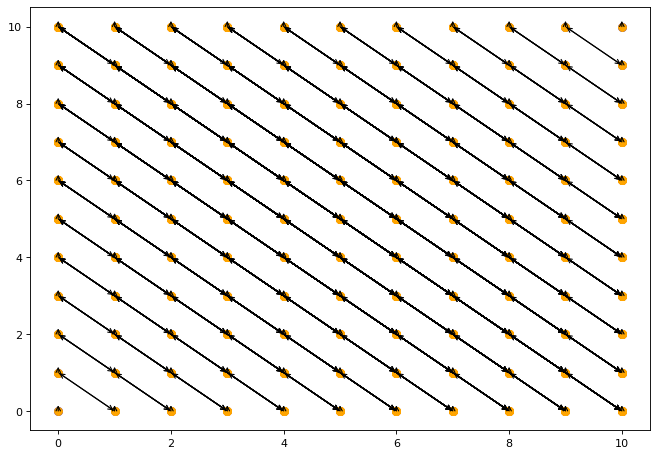

In [55]:
T_only = isl.Map("{ T[i,j] -> T[i',j']: }") # 过滤出访问点.
new_union = union.intersect(T_only)
from islplot.plotter import *
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 7), dpi=80)
plot_map(new_union)
print(new_union)

 
<!-- As you may see, each statement instance is related to *itself* and to one or multiple instances on the same diagonal. -->
如上图所示，每个statement instance都与 *他自己* 以及同一对角线上的一个或多个instance相关.

### Question 

<!-- Define a map `left_42` that contains only the pairs where $(\mathtt{T}(4,2) )$ is on the left,
and a map `right_42` that contains only the pairs where it is on the right. -->
定义一个map `left_42` 只包含 $(\mathtt{T}(4,2) )$ 在左边的pair,
和一个map `right_42`，它只包含它在右边的pair
<!-- *Hint*: map domain and range are sets and can be acted upon. -->
*提示*：map domain和range是集合，可以对其进行操作


In [56]:
left_42 = union.intersect_domain(isl.Set("{ T[i = 4,j = 2] }"))
print(left_42)
right_42 = union.intersect_range(isl.Set("{ T[i = 4,j = 2] }"))
print(right_42)

{ T[i = 4, j = 2] -> S[i' = 6]; T[i = 4, j = 2] -> T[i', j' = 6 - i'] : 0 <= i' <= 6 }
{ T[i, j = 6 - i] -> T[i' = 4, j' = 2] : 0 <= i <= 6; S[i = 6] -> T[i' = 4, j = 2] }


<!-- ###  -->
<!-- Let's compare these relations graphically. -->
从图上比较这些relation:



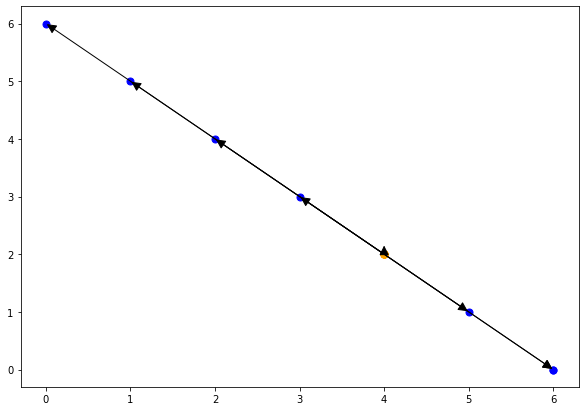

In [64]:
plt.figure(figsize=(10, 7))
plot_map(left_42)

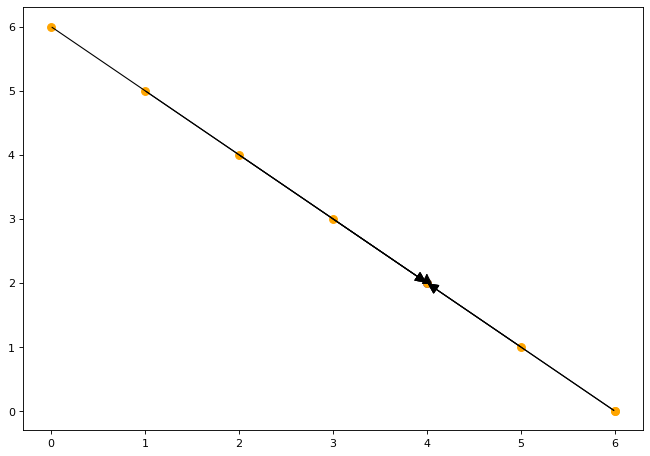

In [65]:
plt.figure(figsize=(10, 7), dpi=80)
plot_map(right_42)

 
<!-- As you may see, the two relations are identical. -->
从上图可以看出, 两个relation是相同的.
<!-- This is again due to the only access to `Z[i+j]` being both read and write.
The statement instance is connected to all other statement instances that access the same data. -->
这又是因为对 `Z[i+j]` 的唯一访问是read和write.
statement instance被连接到了访问相同数据的所有其他statement instance.

<!-- However, it does not necessarily create a *dependence*.  For example, depending on itself does not fully make sense.
For two statement instances to be *dependent*, one of them should be executed *before* another.
That is, the first statement either produces some data necessary for the second one, or uses some data that would be overwritten by the second one.
Dependence computation requires knowing the *order* of statement execution. -->

但是, 它并不一定会创建*依赖*. 例如, 依赖于自身并不完全有意义.
对于两个*依赖*的statement instance, 其中一个应该在另一个*之前*执行.
也就是说, 第一个statement要么生成第二个statement所需的一些数据, 要么使用一些将被第二个statement覆盖的数据.
依赖计算需要知道statement执行的*顺序*.

### Question
<!-- Given the following code, compute and visualize pairs of statements that access the same array element,
and at least one of the accesses is a write. -->
给定以下代码，计算和可视化访问相同数组元素的statement pair, 并且至少其中一个访问是write.

<!-- *Hint:* use disjunction to encode different subscripts in different references to the same array. -->
*Hint:* 使用disjunction对同一数组的不同引用中的不同下标进行编码.

```c
for (i = 0; i < 6; ++i)
  for (j = 0; j < 5; ++j)
S1: X[i][j] = i * j;
for (i = 8; i < 13; ++i)
  for (j = 11; j < 15; ++j)
S2: Y[i][j] = X[i - 8][j - 10] - X[i - 7][j - 11];
```

In [59]:
# step 1. 定义每个statement instance的domain
domain = isl.UnionSet(" { S1[i,j] : 0 <= i < 6 and 0 <= j < 5 ; S2[i,j] : 8 <= i < 13 and 11 <= j < 15 } ")
# S1写入X ; S2写入Y
writes = isl.UnionMap(" { S1[i,j] -> X[a = i, b = j]; S2[i,j] -> Y[a = i, b = j] }")
# S2读取X
reads = isl.UnionMap(" { S2[i,j] -> X[a,b] : (a = i-8 and b = j-10) or ( a= i-7 and b = j - 11) }")

# 添加domain约束
writes = writes.intersect_domain(domain)
reads = reads.intersect_domain(domain)

# 依赖计算
deps = writes.apply_range(reads.reverse())
print(deps)

{ S1[i, j] -> S2[i' = 7 + i, j' = 11 + j] : 0 < i <= 5 and 0 <= j <= 3; S1[i, j] -> S2[i' = 8 + i, j' = 10 + j] : 0 <= i <= 4 and 0 < j <= 4 }


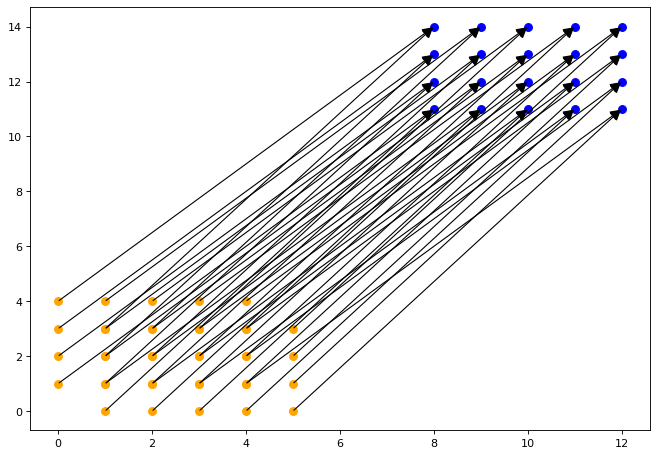

In [66]:
plt.figure(figsize=(10, 7), dpi=80)
plot_map(deps)

### Question
<!-- Select *sample* instances of `S1` and `S2` and plot the instances of other statement that access the same array element. -->
选择 `S1` 和 `S2` 的 *sample* 实例，并绘制访问同一数组元素的其他语句的实例。


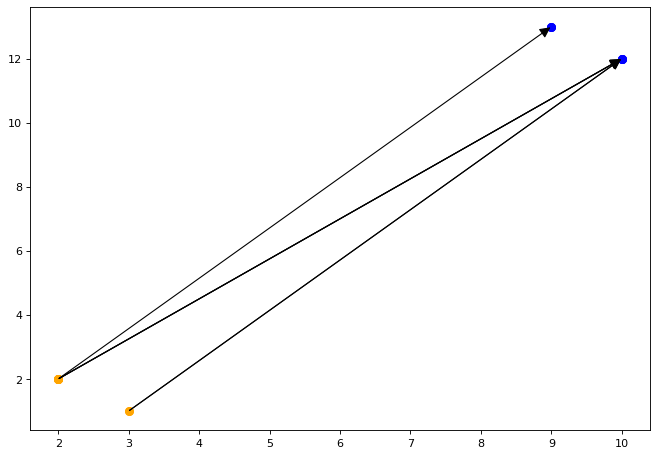

In [68]:
point_22 = isl.Set("{S1[i,j]: i = 2 and j = 2}") # S1 写入X[2,2]
point_1012 = isl.Set("{S2[i,j]: i = 10 and j = 12}") # S2 读取 X[2][2] 和 X[3][1];
sinks = deps.intersect_domain(point_22)
sources = deps.intersect_range(point_1012)
plt.figure(figsize=(10, 7), dpi=80)
plot_map([sinks,sources])